<a href="https://colab.research.google.com/github/MatildaBeinat/KCL-Thesis-data-extraction/blob/main/ML_thesis_KCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 **Imports**

In [1]:
!pip install catboost
!pip install shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
shap.initjs()
import statsmodels.api as sm
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost import FeaturesData
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, roc_curve, auc, roc_auc_score, average_precision_score
from sklearn.utils import resample
from datetime import date, datetime
import time
from csv import writer
from sklearn.model_selection import StratifiedKFold

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.3 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Settings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Process the data

In [3]:
#@title Get and merge data
file_features = "/content/drive/MyDrive/Matilda thesis/official/Features 2000-2023 clean for ML with labels.csv"
file_tsne_concepts = "/content/drive/MyDrive/Matilda thesis/official/data concepts tsne ML.csv"
file_years = "/content/drive/MyDrive/Matilda thesis/official/id + years.csv"
file_TSVD = "/content/drive/MyDrive/Matilda thesis/official/TSVD.csv"
file_rac = "/content/drive/MyDrive/Matilda thesis/official/one hot encoding rac.csv"
file_rcdc = "/content/drive/MyDrive/Matilda thesis/official/category rcdc tsne ML.csv"

file_features = pd.read_csv(file_features)
file_tsne_concepts = pd.read_csv(file_tsne_concepts)
file_years = pd.read_csv(file_years)
file_TSVD = pd.read_csv(file_TSVD)
file_rac = pd.read_csv(file_rac)
file_rcdc = pd.read_csv(file_rcdc)

file_features.drop(['Unnamed: 0'],axis=1,inplace=True)
file_tsne_concepts.drop(['Unnamed: 0'],axis=1,inplace=True)
file_years.drop(['Unnamed: 0'],axis=1,inplace=True)
file_TSVD.drop(['Unnamed: 0'],axis=1,inplace=True)
file_rac.drop(['Unnamed: 0', 'Unnamed: 2'],axis=1,inplace=True)
file_rcdc.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Label'],axis=1,inplace=True)

df_orig = file_features.merge(file_tsne_concepts, on='id')
df_orig = df_orig.merge(file_years, on='id')
df_orig = df_orig.merge(file_TSVD, on='id')
df_orig = df_orig.merge(file_rac, on='id')
df_orig = df_orig.merge(file_rcdc, on='id')

# df_orig contains the full datasets loaded from files, and merged

# we use three data frames
# df_orig = ORIGINAL - the original data loaded from the file
# df_p = PROCESED - the processed data with changed data types, removed NaNs etc, columns translated into strings
# df = SELECTED COLUMNS FOR ML - is the ML frame, which includes only the colums used for training

#@markdown ##### Years range from 2000-2023
final_year = 2018 #@param {type:"number"}

#@title Convert values into string and fill missing values
# Convert column 'journal.id and first author id in to strings
df_p = df_orig.copy()
df_p['journal.id'] = df_p['journal.id'].astype(str)
df_p['first_author_id'] = df_p['first_author_id'].astype(str)

# Add 'no_value' to categorical features

# Fill missing values with 'missing_value'
if 'category_hrcs_rac_clean' in df_p.columns: df_p['category_hrcs_rac_clean'].fillna('no_value', inplace=True)
if 'category_hra_clean' in df_p.columns: df_p['category_hra_clean'].fillna('no_value', inplace=True)
if 'category_rcdc_clean' in df_p.columns: df_p['category_rcdc_clean'].fillna('no_value', inplace=True)
if 'mesh_terms' in df_p.columns: df_p['mesh_terms'].fillna('no_value', inplace=True)
if 'open_access' in df_p.columns: df_p['open_access'].fillna('no_value', inplace=True)
if 'journal.id' in df_p.columns: df_p['journal.id'].fillna('no_value', inplace=True)
if 'supporting_grant_ids' in df_p.columns: df_p['supporting_grant_ids'].fillna('no_value', inplace=True)
if 'first_author_id' in df_p.columns: df_p['first_author_id'].fillna('no_value', inplace=True)
if 'Author_name' in df_p.columns: df_p['Author_name'].fillna('no_value', inplace=True)
if 'first_author_affiliation_id' in df_p.columns: df_p['first_author_affiliation_id'].fillna('no_value', inplace=True)
if 'first_author_affiliation_country' in df_p.columns: df_p['first_author_affiliation_country'].fillna('no_value', inplace=True)

df_all = df_p.copy()
df_p = df_p [df_p ['year']<=final_year]
print(f"Rows: {df_orig.shape[0]}")

Rows: 30700


# Set parameters and columns for the model

In [51]:
#@title Select Parameters
#@markdown ##Model Settings
test_perc = 0.3 #@param {type: "number"}
metric = 'Accuracy' #@param ["Accuracy", "Precision" , "Recall" , "F1", "CrossEntropy"]

#@markdown ##Select Training
training_selection = "label_trials_patents" #@param ["label_patents", "label_trials", "label_trials_patents"] {type:"string"}
training_remove = ["label_patents", "label_trials"]
if training_selection == "label_patents":
  training_remove = ["label_trials", "label_trials_patents"]
if training_selection == "label_trials":
  training_remove = ["label_patents", "label_trials_patents"]



In [52]:
#@title Select Columns to Include
include_id = False #@param {type: "boolean"}

#@markdown #### TSNE A, B and C
include_tsne = True #@param {type: "boolean"}

#@markdown #### TSVD
include_TSVD = True #@param {type: "boolean"}

#@markdown #### Categorical Features
include_all_cat_features = False #@param {type: "boolean"}

include_category_hrcs_rac_clean= False #@param {type: "boolean"}
include_category_hra_clean = True #@param {type: "boolean"}
include_category_rcdc_clean = False #@param {type: "boolean"}
include_mesh_terms = True #@param {type: "boolean"}
include_open_access = True #@param {type: "boolean"}
include_journal_id = True #@param {type: "boolean"}
include_supporting_grant_ids = True #@param {type: "boolean"}
include_first_author_id = True #@param {type: "boolean"}
include_Author_name = True #@param {type: "boolean"}
include_first_author_affiliation_id = True #@param {type: "boolean"}
include_first_author_affiliation_country = True #@param {type: "boolean"}
if(include_all_cat_features):
  include_category_hrcs_rac_clean= True
  include_category_hra_clean = True
  include_category_rcdc_clean = True
  include_mesh_terms = True
  include_open_access = True
  include_journal_id = True
  include_supporting_grant_ids = True
  include_first_author_id = True
  include_Author_name = True
  include_first_author_affiliation_id = True
  include_first_author_affiliation_country = True

#@markdown #### Other
include_authors_count = True #@param {type: "boolean"}
include_recent_citations = False #@param {type: "boolean"}
include_times_cited = True #@param {type: "boolean"}
include_altmetric = True #@param {type: "boolean"}
include_relative_citation_ratio = True #@param {type: "boolean"}
include_reference_ids_count = True #@param {type: "boolean"}
include_count_research_org_country_names = True #@param {type: "boolean"}
include_count_research_org_names = True #@param {type: "boolean"}
include_year = False #@param {type: "boolean"}

#@markdown #### Citations and Associations
include_citing_patents = False #@param {type: "boolean"}
include_associated_trials = False #@param {type: "boolean"}

# drop unnecessary columns
# original list of columns  --> Remember to copy the list of features into "orig_features" if that changes after reloading the original data
# note that the cat_features array is needed by cat boost to treat the features as categorical
orig_features = ['id', 'category_hrcs_rac_clean', 'category_hra_clean',
       'category_rcdc_clean', 'mesh_terms', 'authors_count', 'open_access',
       'recent_citations', 'times_cited', 'journal.id', 'altmetric',
       'supporting_grant_ids', 'relative_citation_ratio',
       'reference_ids_count', 'first_author_id', 'Author_name',
       'first_author_affiliation_id', 'first_author_affiliation_country',
       'count_research_org_country_names', 'count_research_org_names',
       'Citing patents', 'Associated trials', 'label_patents', 'label_trials',
       'a', 'b', 'c', 'Label','0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']

orig_cat_features = ['category_hrcs_rac_clean', 'category_hra_clean', 'category_rcdc_clean', 'mesh_terms', 'open_access', 'journal.id',
                      'supporting_grant_ids', 'first_author_id', 'Author_name', 'first_author_affiliation_id', 'first_author_affiliation_country']

others = ['authors_count','recent_citations', 'times_cited',  'altmetric','relative_citation_ratio',
        'reference_ids_count', 'count_research_org_country_names', 'count_research_org_names', 'year']

drop_items = ['Label']


drop_items.extend(training_remove)
if(not include_id): drop_items.append('id')
if(not include_tsne): drop_items.extend(['a','b','c'])
if(not include_TSVD): drop_items.extend(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])
if(not include_category_hrcs_rac_clean): drop_items.append('category_hrcs_rac_clean')
if(not include_category_hra_clean): drop_items.append('category_hra_clean')
if(not include_category_rcdc_clean): drop_items.append('category_rcdc_clean')
if(not include_mesh_terms): drop_items.append('mesh_terms')
if(not include_authors_count): drop_items.append('authors_count')
if(not include_open_access): drop_items.append('open_access')
if(not include_recent_citations): drop_items.append('recent_citations')
if(not include_times_cited): drop_items.append('times_cited')
if(not include_journal_id): drop_items.append('journal.id')
if(not include_altmetric): drop_items.append('altmetric')
if(not include_supporting_grant_ids): drop_items.append('supporting_grant_ids')
if(not include_relative_citation_ratio): drop_items.append('relative_citation_ratio')
if(not include_reference_ids_count): drop_items.append('reference_ids_count')
if(not include_first_author_id): drop_items.append('first_author_id')
if(not include_Author_name): drop_items.append('Author_name')
if(not include_first_author_affiliation_id): drop_items.append('first_author_affiliation_id')
if(not include_first_author_affiliation_country): drop_items.append('first_author_affiliation_country')
if(not include_count_research_org_country_names): drop_items.append('count_research_org_country_names')
if(not include_count_research_org_names): drop_items.append('count_research_org_names')
if(not include_citing_patents): drop_items.append('Citing patents')
if(not include_associated_trials): drop_items.append('Associated trials')
if(not include_year): drop_items.append('year')

df = df_p.drop(drop_items, axis=1)

print("Remaining features: " + str([i for i in orig_features if i not in drop_items]))
print('')
print("Dropped features: " + str(drop_items))
print('')

# drop the removed columns in cat_feature
cat_features = [x for x in orig_cat_features if x not in drop_items]
print('Number of categorical features =', len(cat_features))

print("Total number of features = " + str(len(df.columns)))
print('')

Remaining features: ['category_hra_clean', 'mesh_terms', 'authors_count', 'open_access', 'times_cited', 'journal.id', 'altmetric', 'supporting_grant_ids', 'relative_citation_ratio', 'reference_ids_count', 'first_author_id', 'Author_name', 'first_author_affiliation_id', 'first_author_affiliation_country', 'count_research_org_country_names', 'count_research_org_names', 'a', 'b', 'c', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']

Dropped features: ['Label', 'label_patents', 'label_trials', 'id', 'category_hrcs_rac_clean', 'category_rcdc_clean', 'recent_citations', 'Citing patents', 'Associated trials', 'year']

Number of categorical features = 9
Total number of features = 83



In [53]:
#@title  Sampling Settings

df_sample = df.copy()
down_sampling_mult = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
over_sampling_mult = 1 #@param {type:"slider", min:1, max:5, step:1}

if(down_sampling_mult !=0):
  zero_rows = df_sample[df_sample[training_selection] == 0]
  num_rows_to_remove = int(len(zero_rows) * down_sampling_mult)
  rows_to_remove = zero_rows.sample(n=num_rows_to_remove, random_state = 42)
  df_sample = df_sample.drop(rows_to_remove.index)

print(df_sample.shape)
print(df_sample[training_selection].sum())


(5756, 83)
2466


# Train the model

In [54]:
target_col = training_selection
X = df_sample.loc[:, df_sample.columns != target_col]
y = df_sample.loc[:, target_col]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = test_perc,
                                                    random_state = 42)

In [56]:
lst = []
for i in range(over_sampling_mult-1):
  for i in list(X_train.index.values):
    if(str(df_sample[target_col].loc[i])=='1'):
      lst.append(list(X_train.loc[i]))

count = len(lst)
print(count)
lst = pd.DataFrame(lst,columns=X_train.columns)

X_train = pd.concat([X_train,lst])

y_train = y_train.append(pd.Series([1] * count),ignore_index=True)

0


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [57]:

print(f"Zeros dataframe: {len(df_sample)-df_sample[target_col].sum()}")
print(f"Ones dataframe: {df_sample[target_col].sum()}")
print(f"Test percentage: {test_perc}")
print('')
print(f"Zeros training : {len(y_train)-y_train.sum()}")
print(f"Ones training: {y_train.sum()}")
print('')
print(f"Zeros test : {len(y_test)-y_test.sum()}")
print(f"Ones test: {y_test.sum()}")

Zeros dataframe: 3290
Ones dataframe: 2466
Test percentage: 0.3

Zeros training : 2315
Ones training: 1714

Zeros test : 975
Ones test: 752


In [58]:
df_sample[target_col].sum()

2466

In [59]:
X_train.head()

,category_hra_clean,mesh_terms,authors_count,open_access,times_cited,journal.id,altmetric,supporting_grant_ids,relative_citation_ratio,reference_ids_count,...,Resources and infrastructure (underpinning),Surgery,Surveillance and distribution,Vaccines,and research governance,ethics,social and economic factors,l,m,n
24263,Biomedical,"Adult, Brain, F-Box Proteins, Female, Genetic ...",16,green,206,1096585.0,3.0,"2708245, 5152497, 5149940, 2782575, 2777284, 2...",4.49,39,...,0,0,0,0,0,0,0,6.807944,-24.559168,6.557088
17912,Biomedical,"Alzheimer Disease, Biomarkers, Cognition Disor...",5,green,123,1033418.0,5.0,no_value,4.56,98,...,0,0,0,0,0,0,0,11.931091,-0.760729,-11.187846
17175,Biomedical,"Animals, Brain, Cerebrovascular Circulation, H...",8,hybrid,274,1092852.0,17.0,"2501186, 3560376",11.82,92,...,0,0,0,0,0,0,0,32.179170,3.853540,7.858792
29137,Biomedical,"Amyloid beta-Protein Precursor, Calcium, Cogni...",3,closed,12,1119070.0,3.0,no_value,0.21,0,...,0,0,0,0,0,0,0,20.793606,-11.394853,24.648810
26525,Population and Society,"Adult, Aged, Aged, 80 and over, Caregivers, De...",6,green,21,1116739.0,NaN,no_value,0.68,10,...,0,0,0,0,0,0,0,36.788210,-6.957282,-6.528225


In [60]:
features = list(X_train.columns)

In [61]:
model_cb = CatBoostClassifier(task_type='GPU',
                              iterations=100,
                              random_state = 2021,
                              eval_metric = metric)

In [62]:
model_cb.fit(X_train, y_train, cat_features= cat_features, plot=True,
             eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.16409
0:	learn: 0.8250186	test: 0.8077591	best: 0.8077591 (0)	total: 14.2ms	remaining: 1.41s
1:	learn: 0.8441301	test: 0.8216561	best: 0.8216561 (1)	total: 27.4ms	remaining: 1.34s
2:	learn: 0.8359394	test: 0.8326578	best: 0.8326578 (2)	total: 40.5ms	remaining: 1.31s
3:	learn: 0.8327128	test: 0.8262884	best: 0.8326578 (2)	total: 54.1ms	remaining: 1.3s
4:	learn: 0.8356912	test: 0.8228141	best: 0.8326578 (2)	total: 67.3ms	remaining: 1.28s
5:	learn: 0.8436337	test: 0.8326578	best: 0.8326578 (2)	total: 80.6ms	remaining: 1.26s
6:	learn: 0.8453711	test: 0.8314997	best: 0.8326578 (2)	total: 93.7ms	remaining: 1.24s
7:	learn: 0.8485977	test: 0.8309207	best: 0.8326578 (2)	total: 107ms	remaining: 1.23s
8:	learn: 0.8488459	test: 0.8303416	best: 0.8326578 (2)	total: 120ms	remaining: 1.22s
9:	learn: 0.8483495	test: 0.8326578	best: 0.8326578 (2)	total: 134ms	remaining: 1.21s
10:	learn: 0.8505833	test: 0.8303416	best: 0.8326578 (2)	total: 147ms	remaining: 1.19s
11:	learn: 0.85033

In [63]:
y_pred = model_cb.predict(X_test)
y_pred_probs = model_cb.predict_proba(X_test)

In [64]:
from google.colab import output
output.enable_custom_widget_manager()

# Test the model

In [65]:
print('% testing  = ', test_perc)
print('metric     = ', metric)
print ('')
test_count = len(X_test)
print('test size  = ', test_count)
zero_count = (y_test == 0).sum().sum()
print('zeros      = ', zero_count)
print('ones       = ', test_count - zero_count)
print('prev. zero = ', zero_count/test_count)
print ('')
print('accuracy   = ', accuracy_score(y_test, y_pred))
print('precision  = ', precision_score(y_test, y_pred))
print('recall     = ', recall_score(y_test, y_pred))
print('F1         = ', f1_score(y_test, y_pred))
print('Lift       = ', accuracy_score(y_test, y_pred)-zero_count/test_count)

print('cm=', confusion_matrix(y_test, y_pred))

#df_sample.columns

% testing  =  0.3
metric     =  Accuracy

test size  =  1727
zeros      =  975
ones       =  752
prev. zero =  0.5645628257093225

accuracy   =  0.8390272148233932
precision  =  0.816
recall     =  0.8138297872340425
F1         =  0.81491344873502
Lift       =  0.2744643891140707
cm= [[837 138]
 [140 612]]


## confusion matrix ML model

Text(95.72222222222221, 0.5, 'Truth')

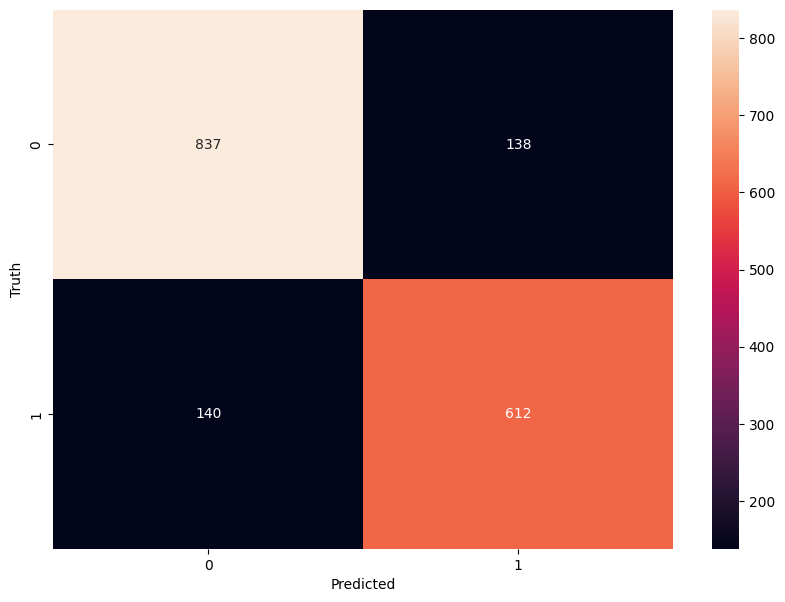

In [66]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting using seaborn heatmap for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# ROC curve ML model

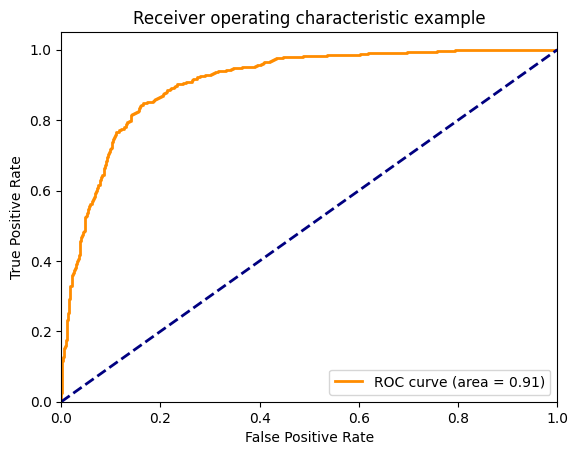

In [ ]:
#compute ROC curve for ML models
#select the column of probabilities for "1", which is the second column of y_pred_probs
y_pred_prob1 = y_pred_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Precision-recall curve ML model

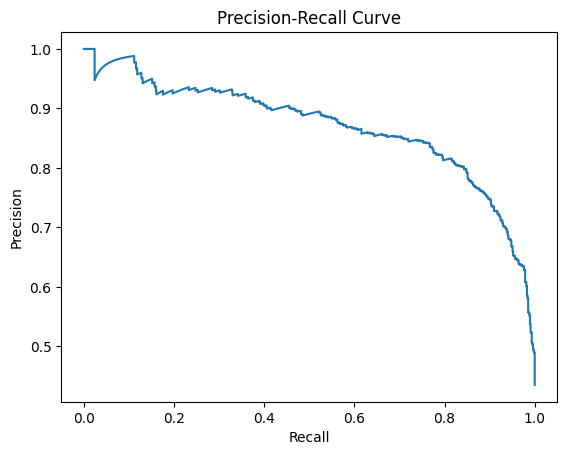

In [ ]:
#compute precision recall curve for ML models
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#Validation

In [67]:
#@title Validation 0s = 1s

# Set the start year for the out-of-time validation data
validation_start_year = 2019

# Create a copy of the original DataFrame to avoid modifying it
df_val = df_all.copy()

# Filter the DataFrame to only include rows where the 'year' column is greater than or equal to the validation start year
df_val = df_val[df_val['year'] >= validation_start_year]

# Separate majority and minority classes
df_majority = df_val[df_val[training_selection]==0]
df_minority = df_val[df_val[training_selection]==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print(df_downsampled[training_selection].value_counts())

# Create a copy of the list of columns to drop
drop_items_val = drop_items.copy()

# Drop the specified columns from the validation DataFrame
df_downsampled = df_downsampled.drop(drop_items_val, axis=1)

# Extract the actual target values for the validation data
y_real = df_downsampled[training_selection].to_numpy()

# Drop the target column from the validation DataFrame
df_downsampled = df_downsampled.drop(training_selection, axis=1)

# Use the trained model to make predictions on the validation data
y_pred_val = model_cb.predict(df_downsampled)

# Print the performance metrics
print('Accuracy  = ', accuracy_score(y_real, y_pred_val))
print('Precision = ', precision_score(y_real, y_pred_val))
print('Recall    = ', recall_score(y_real, y_pred_val))
print('F1 Score  = ', f1_score(y_real, y_pred_val))

0    235
1    235
Name: label_trials_patents, dtype: int64
Accuracy  =  0.6872340425531915
Precision =  0.860655737704918
Recall    =  0.44680851063829785
F1 Score  =  0.5882352941176471


## confusion matrix validation

Text(95.72222222222221, 0.5, 'Truth')

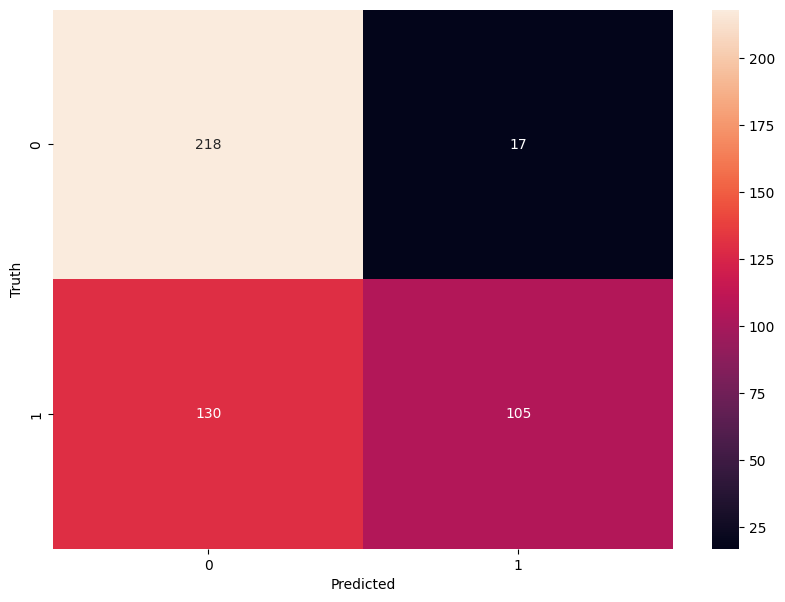

In [68]:
#plot confusion matrix for validation
cm = confusion_matrix(y_real, y_pred_val)

# Plotting using seaborn heatmap for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## ROC curve Validation

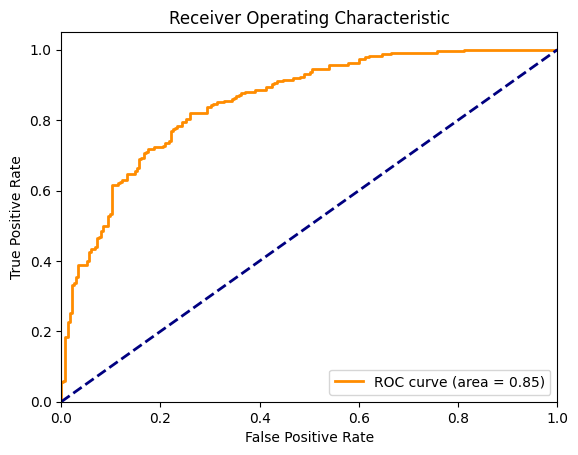

In [69]:
# Use the trained model to predict probabilities for the validation data
y_pred_val_proba = model_cb.predict_proba(df_downsampled)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_real, y_pred_val_proba)

# Calculate the AUC (area under the ROC curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Precision-recall curve validation

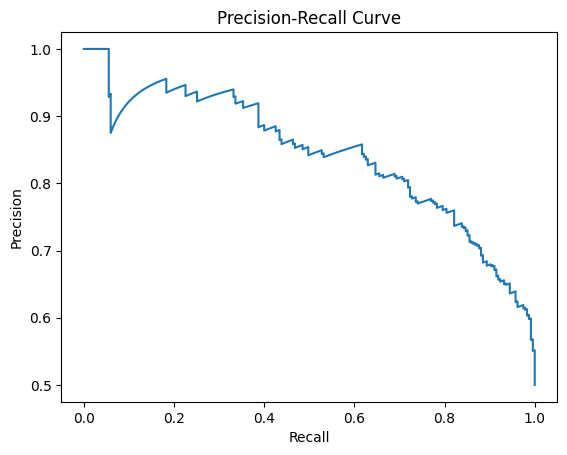

In [70]:
# Use the trained model to predict probabilities for the validation data
y_pred_val_proba = model_cb.predict_proba(df_downsampled)[:, 1]

# Calculate the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_real, y_pred_val_proba)

# Plot the Precision-Recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


# Add results to CSV file

In [ ]:
#@title Add results to the Results.csv file

curr_time = time.strftime("%H:%M:%S", time.gmtime())
date_time = str(date.today()) + " " +curr_time

ones_orig = df_p[training_selection].sum()
zeros_orig = len(df_p) - ones_orig

ones_post = df_sample[training_selection].sum()
zeros_post = len(df_sample) - ones_post

additive = [date_time, final_year, training_selection, df_p.shape[0], df_p.shape[1], zeros_orig, ones_orig, down_sampling_mult, over_sampling_mult,  df_sample.shape[0], df_sample.shape[1], zeros_post, ones_post, test_perc, metric, zero_count/test_count, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)-zero_count/test_count, include_id, include_tsne, include_TSVD, include_category_hrcs_rac_clean, include_category_hra_clean, include_category_rcdc_clean, include_mesh_terms, include_open_access, include_journal_id, include_supporting_grant_ids, include_first_author_id, include_Author_name, include_first_author_affiliation_id, include_first_author_affiliation_country, include_authors_count, include_recent_citations, include_times_cited, include_altmetric, include_relative_citation_ratio, include_reference_ids_count, include_count_research_org_country_names, include_count_research_org_names, include_year, include_citing_patents, include_associated_trials]

with open("/content/drive/MyDrive/Matilda thesis/official/Final/Results.csv", 'a') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(additive)
    f_object.close()

# Get SHAP values

In [ ]:
#Get shap values
explainer = shap.Explainer(model_cb)
shap_values = explainer(X_test)

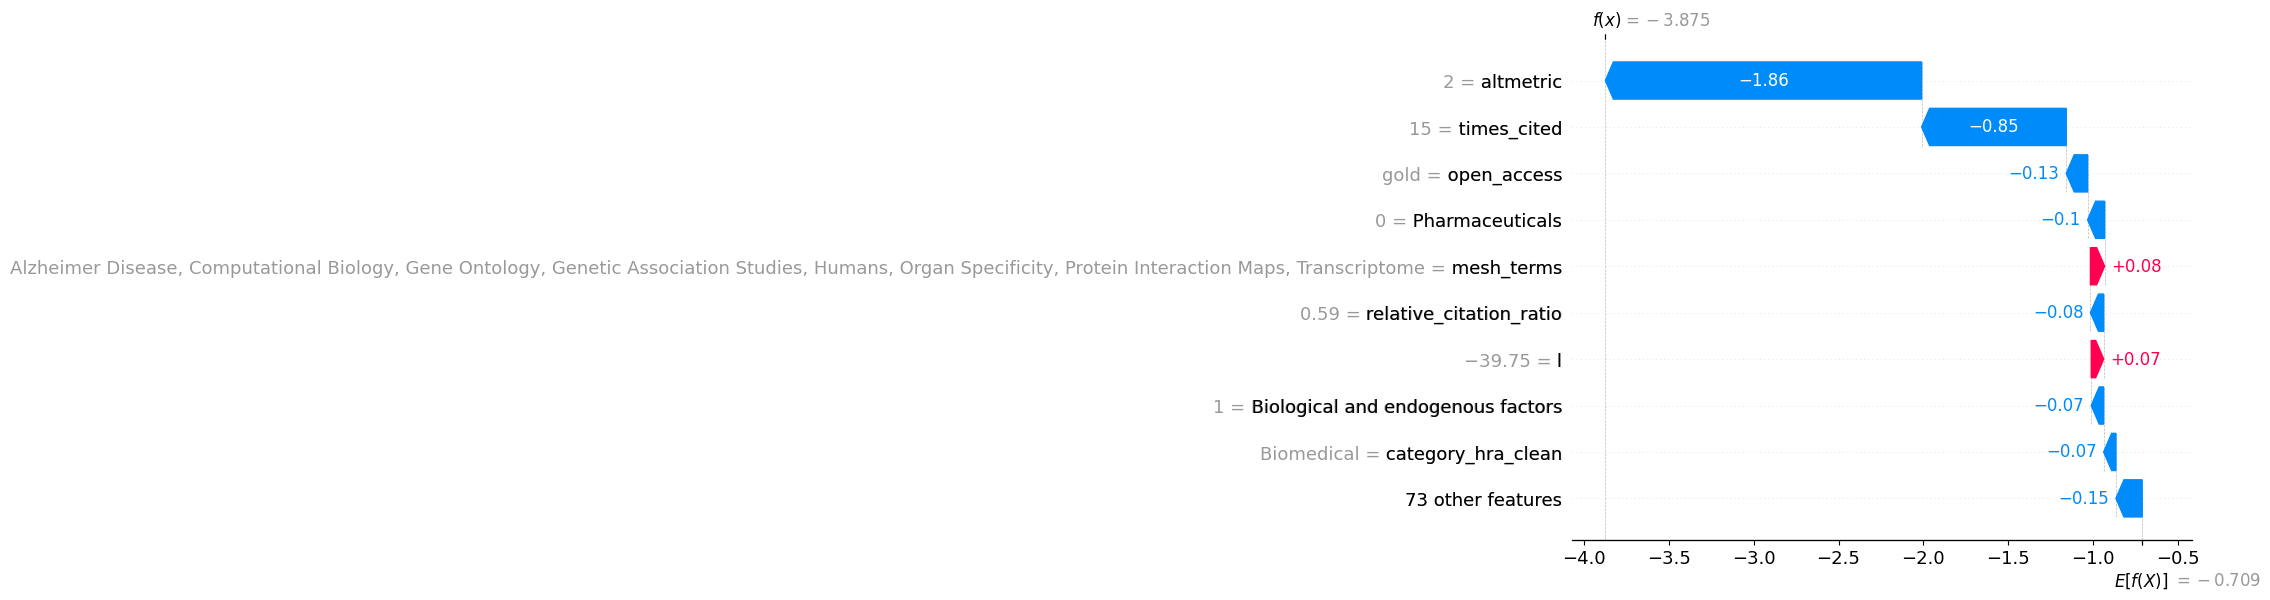

In [ ]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


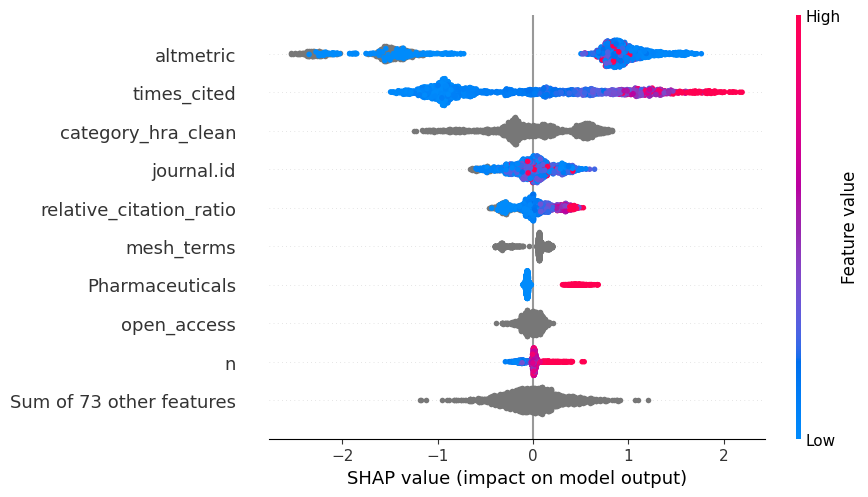

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
column_names_full = X_test.columns.tolist()
#column_names = column_names_full[2:]
column_names_full

#shap.summary_plot(shap_values, X_test, feature_names=['Feature '+str(i) for i in range(X_test.shape[1])])

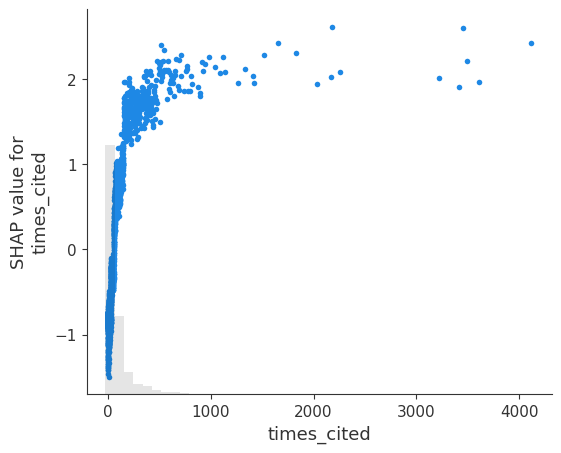

In [ ]:
shap.plots.scatter(shap_values[:,"times_cited"])

In [ ]:
#@title Create the results csv file, only do this once
# dont forget to add to the "additive" variable in the cell above if you add something here
columns = ["Date and Time", "Final Year",  "Label", "Number Rows Orig", "Number Features Orig", "Zeros Orig", "Ones Orig", "Downsampling", "Oversampling", "Number Rows Post", "Number Features Post", "Zeros Post", "Ones Post", "Test Percentage", "Metric", "Prevalence of Zeros", "Accuracy", "Precision", "Recall", "F1", "Lift", "include_id", "include_tsne", "include_TSVD", "include_category_hrcs_rac_clean", "include_category_hra_clean", "include_category_rcdc_clean", "include_mesh_terms", "include_open_access", "include_journal_id", "include_supporting_grant_ids", "include_first_author_id", "include_Author_name", "include_first_author_affiliation_id", "include_first_author_affiliation_country", "include_authors_count", "include_recent_citations", "include_times_cited", "include_altmetric", "include_relative_citation_ratio", "include_reference_ids_count", "include_count_research_org_country_names", "include_count_research_org_names", "include_year", "include_citing_patents", "include_associated_trials"]
results = pd.DataFrame(columns=columns)
results.to_csv("/content/drive/MyDrive/Matilda thesis/official/Final/Results.csv", index=False)